In [393]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# REVISIT
# import seaborn as sns
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler

# Models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from neuralprophet import NeuralProphet


In [394]:
# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [395]:
# Read the Retail Turnover data
turnover_df = pd.read_excel("./ABS_Data/RetailTurnoverByIndustryGroup_850101.xlsx", sheet_name="Data1")
turnover_df.head()

,Unnamed: 0,Turnover ; Total (State) ; Food retailing ;,Turnover ; Total (State) ; Household goods retailing ;,"Turnover ; Total (State) ; Clothing, footwear and personal accessory retailing ;",Turnover ; Total (State) ; Department stores ;,Turnover ; Total (State) ; Other retailing ;,"Turnover ; Total (State) ; Cafes, restaurants and takeaway food services ;",Turnover ; Total (State) ; Total (Industry) ;,Turnover ; Total (State) ; Food retailing ;.1,Turnover ; Total (State) ; Household goods retailing ;.1,...,Turnover ; Total (State) ; Other retailing ;.1,"Turnover ; Total (State) ; Cafes, restaurants and takeaway food services ;.1",Turnover ; Total (State) ; Total (Industry) ;.1,Turnover ; Total (State) ; Food retailing ;.2,Turnover ; Total (State) ; Household goods retailing ;.2,"Turnover ; Total (State) ; Clothing, footwear and personal accessory retailing ;.2",Turnover ; Total (State) ; Department stores ;.2,Turnover ; Total (State) ; Other retailing ;.2,"Turnover ; Total (State) ; Cafes, restaurants and takeaway food services ;.2",Turnover ; Total (State) ; Total (Industry) ;.2
0,Unit,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,...,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions,$ Millions
1,Series Type,Original,Original,Original,Original,Original,Original,Original,Seasonally Adjusted,Seasonally Adjusted,...,Seasonally Adjusted,Seasonally Adjusted,Seasonally Adjusted,Trend,Trend,Trend,Trend,Trend,Trend,Trend
2,Data Type,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,...,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW,FLOW
3,Frequency,Month,Month,Month,Month,Month,Month,Month,Month,Month,...,Month,Month,Month,Month,Month,Month,Month,Month,Month,Month
4,Collection Month,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [396]:
# REVISIT
turnover_df.shape

(518, 22)

In [397]:
# Define short names for the Retail Turnover categories
turnover_categories = ['Food', 'Household_Goods', 'Clothing_and_Footware', 'Department_Stores', 'Other_Retailing', 'Cafes_Restaurants_TakeAway']

In [398]:
# Focus on the Seasonally Adjusted Retail Turnover data

sa_turnover_df = turnover_df.iloc[9:, np.r_[0, 8:14]]
sa_turnover_df.columns = ['Year-Month'] + turnover_categories


In [399]:
# Convert datetime values from string to datetime type
sa_turnover_df['Year-Month'] = pd.to_datetime(sa_turnover_df['Year-Month'])

# Reset the dataframe index to be the datetime column
sa_turnover_df.reset_index(inplace=True, drop=True)
sa_turnover_df = sa_turnover_df.set_index(['Year-Month'])


In [400]:
# Convert data columns from object/string type to numeric
columns = sa_turnover_df.columns.to_list()
sa_turnover_df = sa_turnover_df[columns].apply(pd.to_numeric, errors='coerce')


In [401]:
# REVISIT
sa_turnover_df.dtypes

Food                          float64
Household_Goods               float64
Clothing_and_Footware         float64
Department_Stores             float64
Other_Retailing               float64
Cafes_Restaurants_TakeAway    float64
dtype: object

In [402]:
# REVISIT
sa_turnover_df

,Food,Household_Goods,Clothing_and_Footware,Department_Stores,Other_Retailing,Cafes_Restaurants_TakeAway
Year-Month,,,,,,
1982-04-01,1167.1,653.4,360.7,479.7,507.9,349.8
1982-05-01,1178.6,648.7,362.6,489.2,502.3,346.3
1982-06-01,1203.7,655.7,365.1,479.2,506.9,350.8
1982-07-01,1209.8,660.4,362.0,476.5,503.7,341.5
1982-08-01,1198.7,659.8,359.3,515.2,506.0,342.7
...,...,...,...,...,...,...
2024-04-01,14285.9,5689.7,2940.4,1885.1,5611.4,5398.8
2024-05-01,14383.1,5755.8,2980.5,1873.3,5621.1,5388.4
2024-06-01,14420.0,5818.8,3001.7,1889.6,5671.4,5385.6


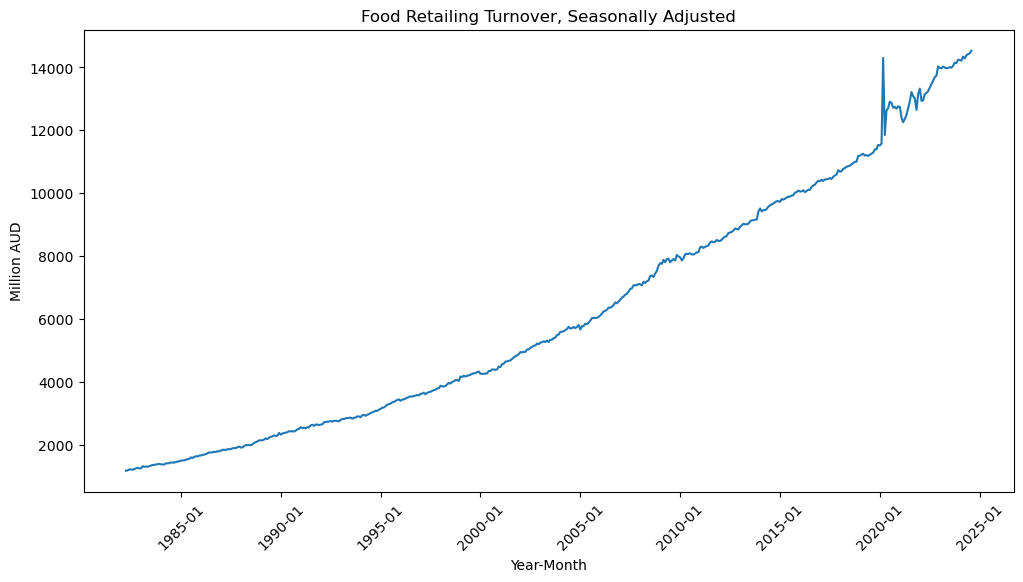

In [403]:
# EDA

#Format visualization
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.title('Food Retailing Turnover, Seasonally Adjusted')
plt.ylabel('Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)

plt.plot(sa_turnover_df.index, sa_turnover_df['Food'])
plt.show()


### Normalize / Scale the dataset

In [404]:
# Normalize / Scale the dataset
# REVISIT

### Split Dataset into Training and Testing components

In [405]:
# str_forecast_from_date = "2020-11-01"
str_forecast_from_date = "2022-09-01"
forecast_from_date = pd.to_datetime(str_forecast_from_date, format='%Y-%m-%d')

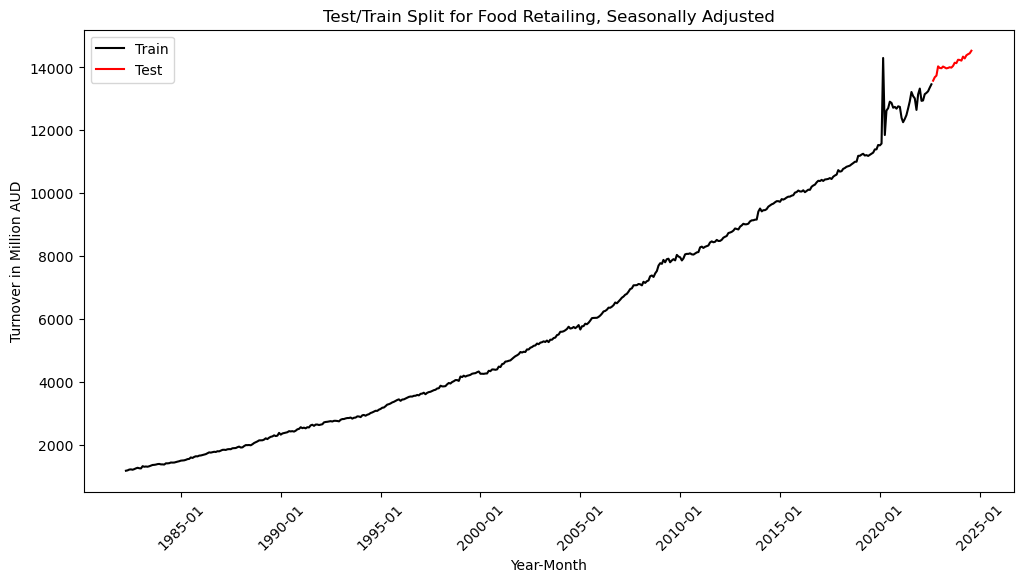

In [406]:
# Splitting the data into training and testing sets
train = sa_turnover_df[sa_turnover_df.index < forecast_from_date]
test = sa_turnover_df[sa_turnover_df.index >= forecast_from_date]

# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

plt.plot(train.index, train['Food'], color="black", label='Train')
plt.plot(test.index, test['Food'], color="red", label='Test')

plt.title('Test/Train Split for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()  # Show legend to differentiate train/test
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Time series prediction - Statistical Models

## (1) ARMA

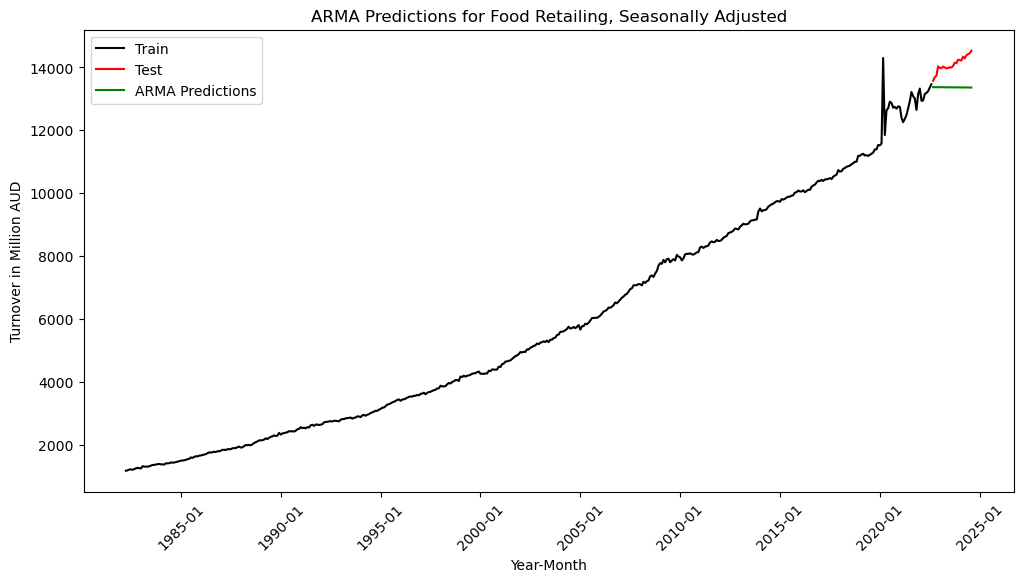

In [407]:
# Define the output
y = train['Food']
y_label_arma = "ARMA Predictions"

# Define ARMA Model
ARMAmodel = SARIMAX(y, order=(1, 0, 1))
ARMAmodel_fit = ARMAmodel.fit(disp=False)

# Generate Turnover predictions
y_pred_arma = ARMAmodel_fit.get_forecast(len(test))
y_pred_arma_df = y_pred_arma.conf_int(alpha=0.05)
y_pred_arma_df[y_label_arma] = ARMAmodel_fit.predict(start=y_pred_arma_df.index[0], end=y_pred_arma_df.index[-1])

# Align the index with test data
y_pred_arma_df.index = test.index

# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Labels and Title
plt.title('ARMA Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()
plt.show()

## (2) ARIMA

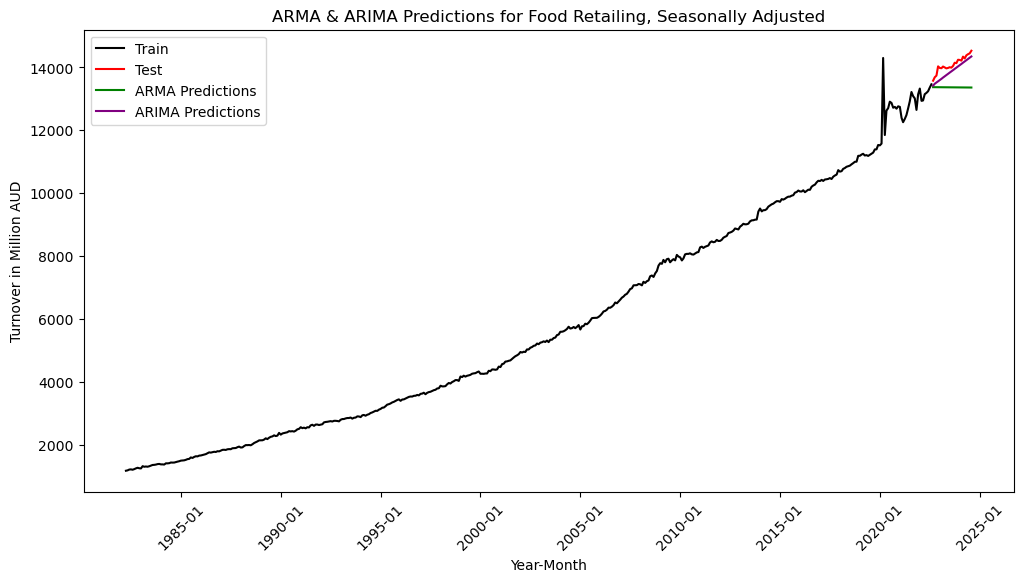

In [408]:
# Define the output
y = train['Food']
y_label_arima = "ARIMA Predictions"

# Define ARIMA Model
ARIMAmodel = ARIMA(y, order = (2, 2, 2)) # Adjust as necessary
ARIMAmodel_fit = ARIMAmodel.fit()

# Generate ARMA predictions
y_pred_arima = ARIMAmodel_fit.get_forecast(len(test.index))
y_pred_arima_df = y_pred_arima.conf_int(alpha = 0.05) 
y_pred_arima_df[y_label_arima] = ARIMAmodel_fit.predict(start = y_pred_arima_df.index[0], end = y_pred_arima_df.index[-1])
y_pred_arima_df.index = test.index

# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Plot ARIMA Predictions
plt.plot(y_pred_arima_df.index, y_pred_arima_df[y_label_arima], color='purple', label=y_label_arima)

# Labels and Title
plt.title('ARMA & ARIMA Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



In [409]:
# REVISIT 

# Calculate RMSE for ARMA
rmse_arma= np.sqrt(mean_squared_error(test['Food'].values, y_pred_arma_df[y_label_arma]))
rsqd_arma = r2_score(test['Food'].values, y_pred_arma_df[y_label_arma])
print("ARMA  -> RMSE: ", rmse_arma, "R-squared: ", rsqd_arma)


# Calculate RMSE for ARIMA
rmse_arima = np.sqrt(mean_squared_error(test['Food'].values, y_pred_arima_df[y_label_arima]))
rsqd_arima = r2_score(test['Food'].values, y_pred_arima_df[y_label_arima])
print("ARIMA -> RMSE: ", rmse_arima, "R-squared: ", rsqd_arima)

ARMA  -> RMSE:  772.1771125809987 R-squared:  -9.866393199514832
ARIMA -> RMSE:  227.29881811858237 R-squared:  0.058444507618069186


# Time series prediction - Neural Network models

## NeuralProphet

In [410]:
# Reinstate date as a DataFrame column, not the index (required by N)
sa_turnover_food_df = sa_turnover_df.reset_index()

# Select the Food category
sa_turnover_food_df = sa_turnover_food_df[["Year-Month", "Food"]]
sa_turnover_food_df

,Year-Month,Food
0,1982-04-01,1167.1
1,1982-05-01,1178.6
2,1982-06-01,1203.7
3,1982-07-01,1209.8
4,1982-08-01,1198.7
...,...,...
504,2024-04-01,14285.9
505,2024-05-01,14383.1
506,2024-06-01,14420.0
507,2024-07-01,14447.2


In [411]:
sa_turnover_food_df['Year-Month']

0     1982-04-01
1     1982-05-01
2     1982-06-01
3     1982-07-01
4     1982-08-01
         ...    
504   2024-04-01
505   2024-05-01
506   2024-06-01
507   2024-07-01
508   2024-08-01
Name: Year-Month, Length: 509, dtype: datetime64[ns]

In [412]:
# Splitting the data into training and testing sets
train_np = sa_turnover_food_df[sa_turnover_food_df['Year-Month'] < forecast_from_date]
test_np = sa_turnover_food_df[sa_turnover_food_df['Year-Month'] >= forecast_from_date]

In [413]:
len(train_np)

485

In [414]:
len(test_np)

24

In [415]:
# Prepare training and testing data in input format required by NeuralProphet
np_train = train_np[['Year-Month', 'Food']].rename(columns={'Year-Month': 'ds', 'Food': 'y'})

# REVISIT
# np_test  =  test_np[['Year-Month', 'Food']].rename(columns={'Year-Month': 'ds', 'Food': 'y'})

In [416]:
# Create and train NeuralProphet model
np_model = NeuralProphet()
metrics = np_model.fit(np_train, freq='MS', epochs=300)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32


Training: |                                                                                         | 0/? [00:…

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (16) is too small than the required number                     for the learning rate finder (219). The results might not be optimal.


Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

Training: |                                                                                         | 0/? [00:…

In [417]:
# np_future_df = np_model.make_future_dataframe(np_train, periods=len(test), n_historic_predictions=len(np_train))
np_future_df = np_model.make_future_dataframe(np_train, periods=len(test_np))

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.794]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [418]:

forecast = np_model.predict(np_future_df)
forecast
# np_model.plot(forecast)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [95.833]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: |                                                                                       | 0/? [00:…

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly
0,2022-09-01,None,13076.525391,13077.640625,-1.113995
1,2022-10-01,None,13113.384766,13113.638672,-0.253485
2,2022-11-01,None,13127.109375,13150.837891,-23.728855
3,2022-12-01,None,13204.138672,13186.838867,17.300686
4,2023-01-01,None,13226.051758,13224.038086,2.014373
5,2023-02-01,None,13213.574219,13261.237305,-47.663643
6,2023-03-01,None,13325.396484,13294.837891,30.558229
7,2023-04-01,None,13287.601562,13332.037109,-44.434971
8,2023-05-01,None,13356.503906,13368.037109,-11.533870
9,2023-06-01,None,13411.488281,13405.235352,6.252562


In [419]:
forecast.dtypes

ds               datetime64[ns]
y                        object
yhat1                   float32
trend                   float32
season_yearly           float32
dtype: object

In [420]:
np_forecast_df = forecast[['ds','yhat1']]
np_forecast_df = np_forecast_df.set_index(['ds'])
np_forecast_df.head()

,yhat1
ds,
2022-09-01,13076.525391
2022-10-01,13113.384766
2022-11-01,13127.109375
2022-12-01,13204.138672
2023-01-01,13226.051758


In [421]:
# Create new dataframe for plotting train/test results
y_pred_np_df = test_np.copy()
y_pred_np_df = y_pred_np_df.set_index(['Year-Month'])


y_pred_np_df = pd.concat([y_pred_np_df, np_forecast_df], axis=1)

In [422]:
y_pred_np_df.tail()

,Food,yhat1
2024-04-01,14285.9,13705.439453
2024-05-01,14383.1,13818.203125
2024-06-01,14420.0,13828.836914
2024-07-01,14447.2,13906.623047
2024-08-01,14530.7,13930.248047


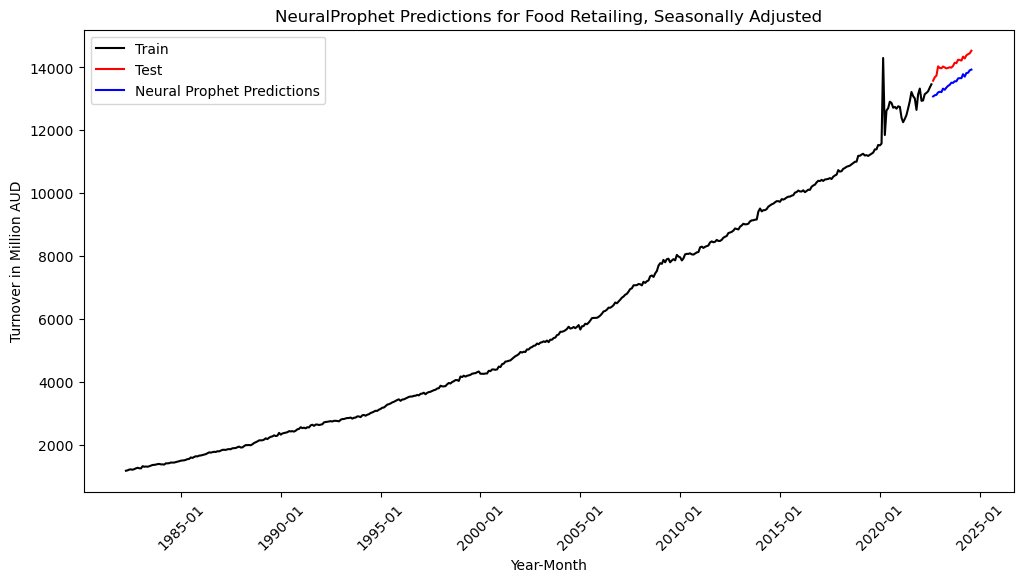

In [423]:
# Define the output
y = train['Food']
y_label_np = "Neural Prophet Predictions"


# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the Neural Prophet predictions
plt.plot(y_pred_np_df.index, y_pred_np_df['yhat1'], color='blue', label=y_label_np)

# Labels and Title
plt.title('NeuralProphet Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()
plt.show()

In [424]:
# Calculate RMSE for NeuralProphet
rmse_np = np.sqrt(mean_squared_error(test['Food'].values, y_pred_np_df['yhat1']))
print("NeuralProphet RMSE: ", rmse_np)

NeuralProphet RMSE:  611.6951534882548


In [425]:
# REVISIT
rmse_np = np.sqrt(mean_squared_error(test['Food'].values, y_pred_np_df['yhat1']))
rsqd_np = r2_score(test['Food'].values, y_pred_np_df['yhat1'])
print("NeuralProphet -> RMSE: ", rmse_np, "R-squared: ", rsqd_np)

NeuralProphet -> RMSE:  611.6951534882548 R-squared:  -5.819014989857294


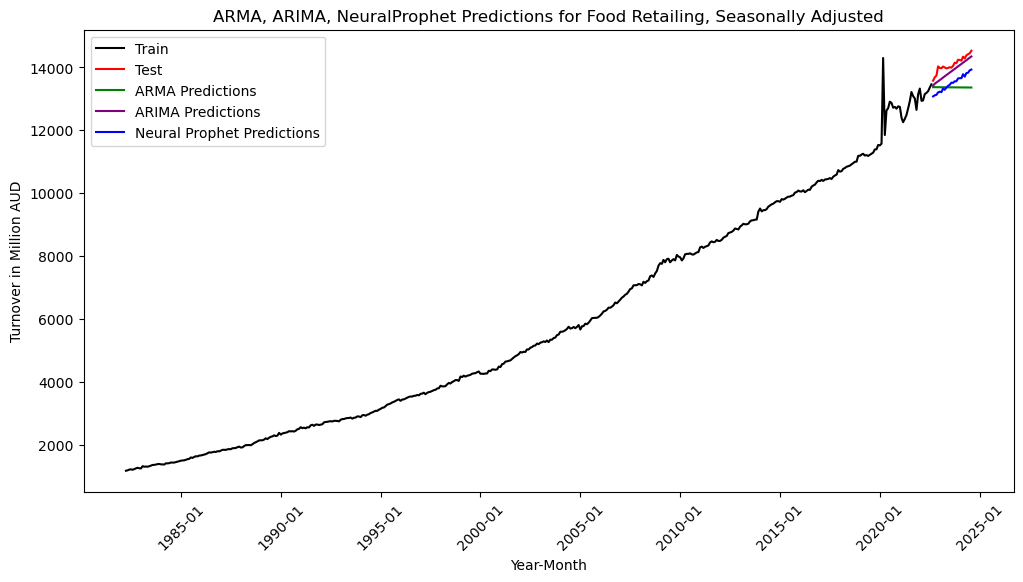

In [426]:
# Plot the Results
# Plotting the train and test sets
figure, axes = plt.subplots(figsize=(12, 6))  # Adjust the figure size to take up more of the page
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(train.index, train['Food'], label='Train', color='black')
plt.plot(test.index, test['Food'], label='Test', color='red')

# Plot the ARMA predictions
plt.plot(y_pred_arma_df[y_label_arma].index, y_pred_arma_df[y_label_arma], color='green', label=y_label_arma)

# Plot ARIMA Predictions
plt.plot(y_pred_arima_df.index, y_pred_arima_df[y_label_arima], color='purple', label=y_label_arima)

# Plot NeuralProphet predictions
plt.plot(y_pred_np_df.index, y_pred_np_df['yhat1'], color='blue', label=y_label_np)

# Labels and Title
plt.title('ARMA, ARIMA, NeuralProphet Predictions for Food Retailing, Seasonally Adjusted')
plt.ylabel('Turnover in Million AUD')
plt.xlabel('Year-Month')
plt.xticks(rotation=45)
plt.legend()
# plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()